In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [3]:


#choppeddata_testset=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()


#choppeddata1=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()

#choppeddata2=pd.read_csv('choppeddata_10_06_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()

#choppeddata1=pd.read_csv('choppeddata_10_04_2021_randomselector_even.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_randomselector_even.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_randomselector_even.csv')#.head()



#choppeddata_testset1=pd.read_csv('choppeddata_10_23_2021_3Xcopiedsuccess_fromGRUlookahead.csv')#.head()
#choppeddata_testset2=pd.read_csv('choppeddata_10_23_2021_3Xcopiedsuccess_fromGRUlookahead_pos2rewardifbuttonpress.csv')#.head()


choppeddata1=pd.read_csv('choppeddata_10_04_2021_V10-retroactiveVals.csv')
choppeddata2=pd.read_csv('choppeddata_10_06_2021_V10-retroactiveVals.csv')
choppeddata3=pd.read_csv('choppeddata_10_13_2021_V10-retroactiveVals.csv')


#choppeddata_testset =pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_test_noposeobs_10_21_2021.csv')
choppeddata_testset =pd.read_csv('choppeddata_10_21_2021_V10-retroactiveVals.csv')


#print(choppeddata1.shape)
#print(choppeddata2.shape)
#print(choppeddata3.shape)

#frames = [choppeddata1,choppeddata2,choppeddata3]
frames = [choppeddata1,choppeddata2,choppeddata3]
choppeddata = pd.concat(frames)

#frames2 = [choppeddata_testset1,choppeddata_testset2]
#choppeddata_testset = pd.concat(frames2)



print("contatenated train data size:")
print(choppeddata.shape)

print("test data size:")
print(choppeddata_testset.shape)

contatenated train data size:
(175656, 10)
test data size:
(21144, 10)


In [4]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

print(State.shape)
print(Labels.shape)




(175656, 10)
total runs: 29276
(29276, 5, 10)
(29276, 10)


In [5]:
#make test set with data outside of training set, because of duplication of successful runs. 


print(choppeddata_testset.shape)
runqty_testset=int(choppeddata_testset.shape[0]/6)
print("total runs:",runqty_testset)

#put chopped data in np.arrays
State_testset=np.zeros((runqty_testset,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels_testset=np.zeros((runqty_testset,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata_testset.shape[0],6):
            State_testset[runcounter][0][:]=(choppeddata_testset[choppedheaders[:]].iloc[i]).tolist()
            State_testset[runcounter][1][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+1]).tolist()
            State_testset[runcounter][2][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+2]).tolist()
            State_testset[runcounter][3][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+3]).tolist()
            State_testset[runcounter][4][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+4]).tolist()
            Labels_testset[runcounter][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1

print(State_testset.shape)
print(Labels_testset.shape)           

(21144, 10)
total runs: 3524
(3524, 5, 10)
(3524, 10)


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [3]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))  #fc means fully connected. Therefore negative outputs ARE possible. 
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist

def train_existing_model(model,train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    """
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    """    
        
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss Per Epoch During GRU Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    return model,losslist


def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE                               

def evaluatefull_maxdiff(gru_model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)


def evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=0.5, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    gru_outputs, targets= evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)
    #print("Vs Training Set")
    #print(gru_outputs[0][4])
    traincounter_falsenegative=0
    traincounter_falsepositive=0
    
    traincounter_truenegative=0
    traincounter_truepositive=0
    for i in range(int(trainy.size)):
        
        if trainy[i]==1  and gru_outputs[0][i]>= cutoff:
            traincounter_truepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truepositive" )
        elif trainy[i]==1  and gru_outputs[0][i]< cutoff:
            traincounter_falsenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif trainy[i]==0 and gru_outputs[0][i]<= cutoff :
            traincounter_truenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif trainy[i]==0 and gru_outputs[0][i]> cutoff:
            traincounter_falsepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsepositive" )     
                
           
    #print("TRAINING SET: Fails for button not pressed:",  train_failzerocounter,"Fails for button pressed:", train_failonecounter )        
    test_successcounter=0
    test_failzerocounter=0
    test_failonecounter=0
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("Vs Test Set")
    #print(gru_outputs[0][4])
    #print("test size: ",testy.size)


    testcounter_falsenegative=0
    testcounter_falsepositive=0
    
    testcounter_truenegative=0
    testcounter_truepositive=0
    for i in range(int(testy.size)):
        
        if testy[i]==1  and gru_outputs[0][i]>= cutoff:
            testcounter_truepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truepositive" )
        elif testy[i]==1  and gru_outputs[0][i]< cutoff:
            testcounter_falsenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif testy[i]==0 and gru_outputs[0][i]<= cutoff :
            testcounter_truenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif testy[i]==0 and gru_outputs[0][i]> cutoff:
            testcounter_falsepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsepositive" )   
    
    print(" vs training data=" ,traincounter_truepositive+traincounter_truenegative,"/",trainy.size, " vs test data=" ,
          testcounter_truepositive+testcounter_truenegative,"/",testy.size,round((100*(testcounter_truepositive+testcounter_truenegative)/testy.size),2),"%", "at cutoff",cutoff )
    
    
    print("TEST SET: True Positives",testcounter_truepositive,"True Negatives", testcounter_truenegative," False Positives",testcounter_falsepositive,"False Negatives", testcounter_falsenegative)
    print("")
    return ( traincounter_truepositive+traincounter_truenegative, testcounter_truepositive+testcounter_truenegative)



def evaluatefull_goodmove(gru_model, train_x, train_y, test_x, test_y,cutoff=0.6, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    gru_outputs, targets= evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)
    #print("Vs Training Set")
    #print(gru_outputs[0][4])
    traincounter_falsenegative=0
    traincounter_falsepositive=0
    
    traincounter_truenegative=0
    traincounter_truepositive=0
    for i in range(int(trainy.size)):
        
        if trainy[i]==1  and gru_outputs[0][i]>= cutoff:
            traincounter_truepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truepositive" )
        elif trainy[i]==1  and gru_outputs[0][i]< cutoff:
            traincounter_falsenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif trainy[i]==0 and gru_outputs[0][i]<= cutoff :
            traincounter_truenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif trainy[i]==0 and gru_outputs[0][i]> cutoff:
            traincounter_falsepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsepositive" )     
                
           
    #print("TRAINING SET: Fails for button not pressed:",  train_failzerocounter,"Fails for button pressed:", train_failonecounter )        
    test_successcounter=0
    test_failzerocounter=0
    test_failonecounter=0
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("Vs Test Set")
    #print(gru_outputs[0][4])
    #print("test size: ",testy.size)


    testcounter_falsenegative=0
    testcounter_falsepositive=0
    
    testcounter_truenegative=0
    testcounter_truepositive=0
    for i in range(int(testy.size)):
        
        if testy[i]==1  and gru_outputs[0][i]>= cutoff:
            testcounter_truepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truepositive" )
        elif testy[i]==1  and gru_outputs[0][i]< cutoff:
            testcounter_falsenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif testy[i]==0 and gru_outputs[0][i]<= cutoff :
            testcounter_truenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif testy[i]==0 and gru_outputs[0][i]> cutoff:
            testcounter_falsepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsepositive" )   
    
    print(" vs training data=" ,traincounter_truepositive+traincounter_truenegative,"/",trainy.size, " vs test data=" ,
          testcounter_truepositive+testcounter_truenegative,"/",testy.size,round((100*(testcounter_truepositive+testcounter_truenegative)/testy.size),2),"%", "at cutoff",cutoff )
    
    
    print("TEST SET: True Positives",testcounter_truepositive,"True Negatives", testcounter_truenegative," False Positives",testcounter_falsepositive,"False Negatives", testcounter_falsenegative)
    print("")
    return ( traincounter_truepositive+traincounter_truenegative, testcounter_truepositive+testcounter_truenegative)

x.shape (29276, 5, 10)
x.shape (3524, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/500 Done, Total Loss: 0.06341051375656798   Time Elapsed: 0.603418999999974 seconds
Epoch 80/500 Done, Total Loss: 0.05139566000485629   Time Elapsed: 0.5909279999999626 seconds
Epoch 120/500 Done, Total Loss: 0.04343109691450209   Time Elapsed: 0.6265119999999911 seconds
Epoch 160/500 Done, Total Loss: 0.036941750677661936   Time Elapsed: 0.5858990000000404 seconds
Epoch 200/500 Done, Total Loss: 0.03141465234946002   Time Elapsed: 0.6033599999999524 seconds
Epoch 240/500 Done, Total Loss: 0.027289168704954677   Time Elapsed: 0.609403000000043 seconds
Epoch 280/500 Done, Total Loss: 0.023753504726316845   Time Elapsed: 0.6083280000000286 seconds
Epoch 320/500 Done, Total Loss: 0.022078846487331025   Time Elapsed: 0.6141699999999446 seconds
Epoch 360/500 Done, Total Loss: 0.019394770162506847   Time Elapsed: 0.6069100000000844 seconds
Epoch 400/500 Done, Total Loss: 0.018033874650044662   Time Elapsed: 0.6228570000000673 seconds
Epoch 440/500 Done, Total Loss: 0.01656021611568

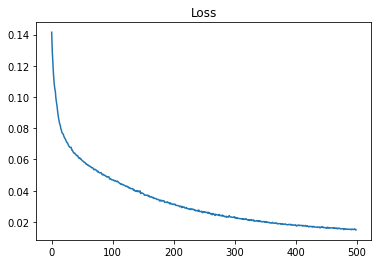

Vs Training Set
0.10517064
Vs Test Set

 vs training data= 29171 / 29275  vs test data= 1630 / 3507 46 % at max difference 0.4
11_02_2021
model saved


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
lr = 0.0005
batch_size = 64*2
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

#X=State[:,:,0:9]
X=State[:,:,:]
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


X_testset=State_testset[:,:,:]
y_testset=Labels_testset[:,lookback-1]
print("x.shape",X_testset.shape)

y_testset=y_testset.reshape(runqty_testset,1)


random_seed=int(time.time())
#print(int(time.time()))
train_x_trainset, test_x_trainset, train_y_trainset,test_y_trainset = train_test_split(X, y, test_size= float(.00001),#.25 #0.33, 
                                                   random_state=random_seed)

train_x_testset, test_x_testset, train_y_testset,test_y_testset = train_test_split(X_testset, y_testset, test_size=.995,#.25 #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x_trainset), torch.from_numpy(train_y_trainset))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x_testset ), torch.from_numpy( test_y_testset) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )




gru_model1, losslist1 =train(train_loader, lr , hidden_dim=128, EPOCHS=500 ,model_type="GRU") #1500  #had low total loss with batch size 32
train2 ,test2=evaluatefull_maxdiff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,maxdifference=0.4)

import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model1,"currentmodel_V10A_retroactiveVals_3datasets"+todaydate+"-b.pt")


print("model saved")


In [15]:

device = torch.device("cuda")
train2 ,test2=evaluatefull_maxdiff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,maxdifference=0.1)
train2 ,test2=evaluatefull_maxdiff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,maxdifference=0.2)
train2 ,test2=evaluatefull_maxdiff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,maxdifference=0.3)
train2 ,test2=evaluatefull_maxdiff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,maxdifference=0.4)


Vs Training Set
0.10517064
Vs Test Set

 vs training data= 22429 / 29275  vs test data= 592 / 3507 16 % at max difference 0.1
Vs Training Set
0.10517064
Vs Test Set

 vs training data= 27788 / 29275  vs test data= 1006 / 3507 28 % at max difference 0.2
Vs Training Set
0.10517064
Vs Test Set

 vs training data= 28897 / 29275  vs test data= 1329 / 3507 37 % at max difference 0.3
Vs Training Set
0.10517064
Vs Test Set

 vs training data= 29171 / 29275  vs test data= 1630 / 3507 46 % at max difference 0.4


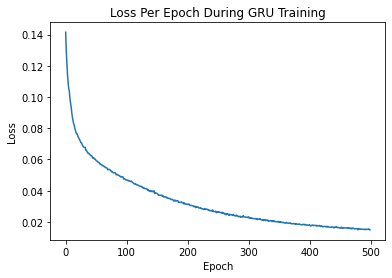

In [9]:
plt.plot(losslist1)
plt.title("Loss Per Epoch During GRU Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [103]:
print(22296 / 29275 )
print(27774 / 29275 )
print(28903 / 29275 )
print(29150 / 29275 )

0.761605465414176
0.9487275832621691
0.9872929120409906
0.9957301451750641


In [42]:
def evaluate_episode(model, data, verbose=False):

    device = torch.device("cpu")
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

"""
def evaluate_episode(model, data,  maxdifference=0.2, verbose=False):
    device = torch.device("cpu")
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out
"""

'\ndef evaluate_episode(model, data,  maxdifference=0.2, verbose=False):\n    device = torch.device("cpu")\n    model.eval()\n    inp = torch.from_numpy(np.array(data)) # should be 5x1\n    h = model.init_hidden(inp.shape[0])\n    #print("inp",inp)\n    #print("labs",labs)\n    #print("h",h)\n    out, h = model(inp.to(device).float(), h)\n    #print("model output",out)\n    return out\n'

## Test model on new data

In [5]:
#gru_model3=torch.load('currentmodel_9steplookhead10_23_2021.pt',map_location=torch.device('cpu'))
gru_model3=torch.load('currentmodel_V10A_retroactiveVals_3datasets11_02_2021-b.pt',map_location=torch.device('cpu'))

gru_model3.eval()
print("loaded")

loaded


/home/scott/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/scott/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/scott/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attr

In [12]:
device = torch.device("cpu")
train2 ,test2=evaluatefull_maxdiff(gru_model3, train_x_trainset,
                                   train_y_trainset, test_x_testset, test_y_testset,maxdifference=.5)




Vs Training Set
0.10517061
Vs Test Set

 vs training data= 29232 / 29275  vs test data= 1901 / 3507 54 % at max difference 0.5


In [22]:
randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
prediction=evaluate_episode(gru_model3, exampledata)

print("prediction",float(prediction), "  actual",test_y[randomindex])

index= 203


NameError: name 'test_x' is not defined

## simlulate a buffer of 10 timesteps entering the classifier over a 1 episode, and classifying them. Filling empty data with zeroes or ones

In [12]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 188
final partial data
[[[1.         0.64779416 0.68590197 0.69517914 0.69903447 0.71459429
   0.71267351 0.71409191 0.71673093 0.72399386]
  [1.         0.52154944 0.52310862 0.53282553 0.52718083 0.53709991
   0.52978522 0.54277099 0.53688102 0.54443726]
  [1.         0.8726286  0.96482141 0.95083008 0.94447182 0.93691809
   0.95239155 0.9493714  0.95276295 0.95638539]
  [1.         0.50752062 0.50852903 0.49810241 0.50102952 0.4947311
   0.50046923 0.49000781 0.49422322 0.48543027]
  [1.         0.62007232 0.67079484 0.67376652 0.67304434 0.68618886
   0.68665851 0.69233506 0.69529406 0.70288601]]]

full data
[[[0.64779416 0.68590197 0.69517914 0.69903447 0.71459429 0.71267351
   0.71409191 0.71673093 0.72399386 0.7219988 ]
  [0.52154944 0.52310862 0.53282553 0.52718083 0.53709991 0.52978522
   0.54277099 0.53688102 0.54443726 0.53999553]
  [0.8726286  0.96482141 0.95083008 0.94447182 0.93691809 0.95239155
   0.9493714  0.95276295 0.95638539 0.94038139]
  [0.50752062 0.508529

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [6]:
#originaldata=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_10_21_2021.csv')#.head()
#originaldata=pd.read_csv('forcetorquebuttonresults_squarepeg_withbutton_normalrewardsrun2_10_28_2021.csv')#.head()

#one of the training sets
#originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
#New data
originaldata=pd.read_csv('AllGRUresults_squarepeg_withbutton_normalrewardsrun2_10_28_2021.csv')#.head()



print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

originaldata[headers[0:15]].iloc[0:6]

(3904, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,header10,header11,header12,header13,header14
0,0.047428,0.045197,0.054271,0.044387,0.028308,0.041213,0.041831,0.035016,0.042993,0.031118,0.033736,0.048568,0.036269,0.009823,-0.173598
1,-0.155119,-0.155878,-0.154973,-0.158897,-0.169143,-0.163121,-0.165861,-0.160742,-0.166939,-0.157939,-0.149215,-0.155161,-0.163619,-0.154572,-0.152588
2,0.872336,0.874709,0.877295,0.872687,0.882188,0.879354,0.883103,0.878233,0.880431,0.883705,0.878938,0.883125,0.883213,0.877825,0.858028
3,0.221875,0.222495,0.220165,0.222392,0.224162,0.221662,0.223603,0.222480,0.222628,0.221598,0.221143,0.221967,0.223605,0.220040,0.215563
4,0.051532,0.050782,0.052250,0.050566,0.049156,0.049900,0.050844,0.049759,0.052674,0.051899,0.052331,0.052541,0.050093,0.037025,-0.084712
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
def fullepisodereview(model,data,firstindex,finalindex):
   
    
    for i in range(21):
        classifytest=originaldata[headers[i:10+i]].iloc[firstindex:finalindex].to_numpy()
        if i==0:
            print(classifytest)
        labelstest=originaldata[headers[i:10+i]].iloc[finalindex].to_numpy()
        actiontest=originaldata[headers[i:10+i]].iloc[finalindex+2].to_numpy()
        #print(classifytest)
        classifytest=np.expand_dims(classifytest, axis=0)
        #print(classifytest.shape)
        #print(labelstest)

        outputfull=evaluate_episode(model, classifytest)

        #print("")

        #print("evaluating 1st timestep repeated 10 times")


        #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])

        if abs(float(outputfull)-labelstest[9])>0.3:
            result="X"
        else:
            result="OK"
            okcounter+=1
        #print("prediction from timestep",i,"-",i+9," :",float(outputfull),"actual",labelstest[9], result)
        print("prediction from timestep",i,"-",i+9," :",float(outputfull),"actual",labelstest[9], "action taken",actiontest[9])
        
        
    print("okcounter",okcounter)

In [44]:
device = torch.device("cuda")
fullepisodereview(gru_model1,originaldata,912,917)
#fullepisodereview(gru_model1,originaldata,4296,4301)

[[ 0.06411754]
 [-0.13782141]
 [ 0.85560811]
 [ 0.17427168]
 [ 0.07708723]]


RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 1

In [30]:
fullepisodereview(gru_model1,originaldata,936,936+5)

[[ 0.01673176  0.02094873  0.02043682  0.00905836  0.01495339  0.01739852
  -0.17135093 -0.14083053 -0.12710724 -0.13448924]
 [-0.12478415 -0.12110997 -0.13552826 -0.14611768 -0.14524656 -0.15639022
  -0.24416483 -0.250664   -0.2452074  -0.2389723 ]
 [ 0.86480449  0.85868919  0.86811453  0.86388829  0.85639947  0.85855561
   0.85032626  0.84538851  0.84744203  0.86533119]
 [ 0.17863759  0.17689127  0.17703272  0.18408015  0.188513    0.19131829
   0.24789705  0.25695509  0.25804859  0.25813848]
 [ 0.09818723  0.09876841  0.09673929  0.09779251  0.09714956  0.08552771
  -0.08731049 -0.07318661 -0.06837064 -0.06806396]]


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [26]:
fullepisodereview(gru_model3,originaldata,1528,1533)

[[ 0.03203651  0.03356945 -0.11993227 -0.10995695 -0.08623641 -0.09979779
  -0.10239876 -0.08168671 -0.04640817 -0.03281875]
 [-0.09469094 -0.10405679 -0.156708   -0.18081236 -0.17498395 -0.16910481
  -0.16716771 -0.21463969 -0.25876177 -0.31411639]
 [ 0.86376557  0.86692481  0.86887185  0.85601164  0.86355667  0.86225604
   0.87889304  0.84948537  0.84386374  0.84482862]
 [ 0.19176743  0.19105685  0.22993816  0.24318724  0.24157555  0.24063523
   0.23676126  0.27498038  0.30624308  0.35272177]
 [ 0.09323632  0.09086092 -0.0250872  -0.02724445 -0.01001221 -0.01439866
  -0.02304249 -0.0067124   0.0048039   0.01756891]]
prediction from timestep 0 - 9  : 0.13512420654296875 actual 0.0 action taken 3.0
prediction from timestep 1 - 10  : 0.12321990728378296 actual 0.0 action taken 0.0
prediction from timestep 2 - 11  : 0.2302221655845642 actual 0.0 action taken 0.0
prediction from timestep 3 - 12  : 0.0430421382188797 actual 0.0 action taken 0.0
prediction from timestep 4 - 13  : 0.04104745

In [27]:
fullepisodereview(gru_model3,originaldata,534,539)

[[ 0.21248463  0.17398277  0.34175116  0.32362199  0.23494524  0.30553594
   0.35609379  0.57016236  0.41354671  0.54203749]
 [ 4.          4.          4.          4.          4.          4.
   3.          3.          3.          3.        ]
 [ 0.08123953  0.0788702   0.07351046  0.0820183   0.08760322  0.29854562
   0.39902159  0.41529069  0.44237287  0.41603368]
 [-0.12307587 -0.11823409 -0.10303859 -0.10187377 -0.11565779 -0.11745899
  -0.13447747 -0.12536176 -0.13655761 -0.11965758]
 [ 0.86084557  0.85495912  0.84888428  0.86058184  0.85884033  0.80997601
   0.79728433  0.7756234   0.79362505  0.85210465]]
prediction from timestep 0 - 9  : 0.01146937906742096 actual 0.1826020146770348 action taken 0.0
prediction from timestep 1 - 10  : 0.044586122035980225 actual 0.1762245765820027 action taken 0.0
prediction from timestep 2 - 11  : nan actual 0.1802675193641447 action taken 0.0
prediction from timestep 3 - 12  : nan actual 0.1775513913840769 action taken 0.0
prediction from timest

In [16]:
def evaluatedataset_actions(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    #print(cutofflist[4])
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    GRUoutputlist_truepositive=[]
    GRUoutputlist_falsenegative=[]
    GRUoutputlist_falsepositive=[]
    GRUoutputlist_truenegative=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),8):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+7]==4 : #if action was "down"

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                cutoff=0.5
                for k in range(len(cutofflist)):
                    if outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                        GRUoutputlist.append(outputfull[0][0][0])
                        if k==4:
                            GRUoutputlist_truepositive.append(outputfull[0][0][0])
 
                    elif  outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                        if k==4:
                            GRUoutputlist_falsenegative.append(outputfull[0][0][0])

            elif (dataset[headers[h-1]].iloc[i+7]==0 or dataset[headers[h-1]].iloc[i+7]==1 or
                dataset[headers[h-1]].iloc[i+7]==2 or dataset[headers[h-1]].iloc[i+7]==3) : #if action was not"down"

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                #GRUoutputlist.append(outputfull[0][0])
                GRUoutputlist.append(outputfull[0][0][0])
                
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                #cutoff=0.5
                for k in range(len(cutofflist)):
                    if outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                        if k==4:
                            GRUoutputlist_truenegative.append(outputfull[0][0][0])
                    elif  outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
                        if k==4:
                            GRUoutputlist_falsepositive.append(outputfull[0][0][0])
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   
    GRUoutputlist.sort()
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(GRUoutputlist)
    plt.xlabel('10-Timestep Sequence Evaluated')
    plt.ylabel('GRU Output Value')
    plt.title('Sorted GRU Outputs For All 10-Timestep Sequences \n in 10/28/2021 DQN Training Run')
    
    
    GRUoutputlist_truepositive.sort()
    GRUoutputlist_truenegative.sort()
    GRUoutputlist_falsenegative.sort()
    GRUoutputlist_falsepositive.sort()
    plt.subplot(1, 2, 2)
    plt.plot(GRUoutputlist_truepositive,label='True Positives')
    plt.plot(GRUoutputlist_truenegative,label='True Negatives')
    plt.plot(GRUoutputlist_falsenegative,label='False Negatives')
    plt.plot(GRUoutputlist_falsepositive,label='False Positives')
    
    plt.legend(loc='lower right')
    plt.xlabel('10-Timestep Sequence Evaluated')
    plt.ylabel('GRU Output Value')
    plt.title('Separability Plot for GRU Outputs for Identifying \n Downward Actions Using a Threshold of 0.6')
    plt.show()
    
    
    return GRUoutputlist

def evaluatedataset_actions_scatterplot(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    #print(cutofflist[4])
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    GRUoutputlist_truepositive=[]
    GRUoutputlist_falsenegative=[]
    GRUoutputlist_falsepositive=[]
    GRUoutputlist_truenegative=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),8):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+7]==4 : #if action was "down"

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                cutoff=0.5
                for k in range(len(cutofflist)):
                    if outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                        GRUoutputlist.append(outputfull[0][0][0])
                        if k==4:
                            GRUoutputlist_truepositive.append(outputfull[0][0][0])
 
                    elif  outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                        if k==4:
                            GRUoutputlist_falsenegative.append(outputfull[0][0][0])

            elif (dataset[headers[h-1]].iloc[i+7]==0 or dataset[headers[h-1]].iloc[i+7]==1 or
                dataset[headers[h-1]].iloc[i+7]==2 or dataset[headers[h-1]].iloc[i+7]==3) : #if action was not"down"

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                #GRUoutputlist.append(outputfull[0][0])
                GRUoutputlist.append(outputfull[0][0][0])
                
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                #cutoff=0.5
                for k in range(len(cutofflist)):
                    if outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                        if k==4:
                            GRUoutputlist_truenegative.append(outputfull[0][0][0])
                    elif  outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
                        if k==4:
                            GRUoutputlist_falsepositive.append(outputfull[0][0][0])
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   
    GRUoutputlist.sort()
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(GRUoutputlist)
    plt.xlabel('10-Timestep Sequence Evaluated')
    plt.ylabel('GRU Output Value')
    plt.title('Sorted GRU Outputs For All 10-Timestep Sequences \n in 10/28/2021 DQN Training Run')
    
    
    GRUoutputlist_truepositive.sort()
    GRUoutputlist_truenegative.sort()
    GRUoutputlist_falsenegative.sort()
    GRUoutputlist_falsepositive.sort()
    plt.subplot(1, 2, 2)
    plt.plot(GRUoutputlist_truepositive,label='True Positives')
    plt.plot(GRUoutputlist_truenegative,label='True Negatives')
    plt.plot(GRUoutputlist_falsenegative,label='False Negatives')
    plt.plot(GRUoutputlist_falsepositive,label='False Positives')
    
    plt.legend(loc='lower right')
    plt.xlabel('10-Timestep Sequence Evaluated')
    plt.ylabel('GRU Output Value')
    #plt.title('Sorted Confusion Matrix Results for \n GRU Outputs with threshold of 0.6')
    plt.title('Separability Plot for \n GRU Outputs with Threshold of 0.6 for iIentifying Downward Actions')
    
    plt.show()
    
    
    return GRUoutputlist

At cuttoff of 0.2  truepositive 1690 truenegative 3348 falsepositive 2425 falsenegative 1323 Accuracy 57.3412246756203 %
At cuttoff of 0.3  truepositive 1443 truenegative 3997 falsepositive 1776 falsenegative 1570 Accuracy 61.91668563623947 %
At cuttoff of 0.4  truepositive 1201 truenegative 4564 falsepositive 1209 falsenegative 1812 Accuracy 65.61575233325746 %
At cuttoff of 0.5  truepositive 960 truenegative 5015 falsepositive 758 falsenegative 2053 Accuracy 68.00591850671523 %
At cuttoff of 0.6  truepositive 714 truenegative 5329 falsepositive 444 falsenegative 2299 Accuracy 68.77987707716822 %
At cuttoff of 0.7  truepositive 487 truenegative 5555 falsepositive 218 falsenegative 2526 Accuracy 68.76849533348509 %
At cuttoff of 0.75  truepositive 378 truenegative 5624 falsepositive 149 falsenegative 2635 Accuracy 68.3132255861598 %
At cuttoff of 0.8  truepositive 307 truenegative 5671 falsepositive 102 falsenegative 2706 Accuracy 68.04006373776463 %
At cuttoff of 0.9  truepositive 186

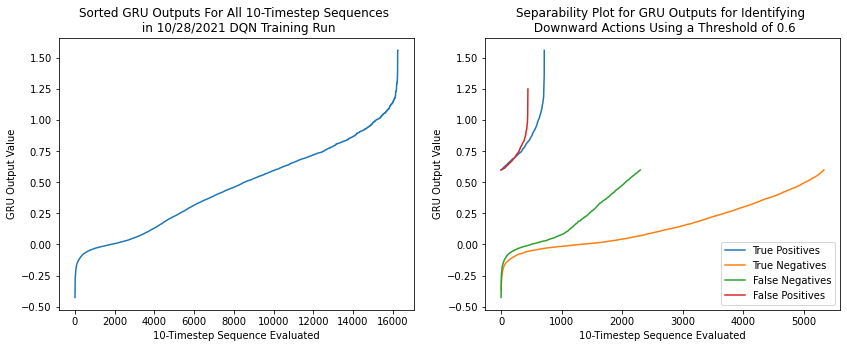

In [17]:
device = torch.device("cpu")
outputlist=evaluatedataset_actions(gru_model3,originaldata)

In [72]:
print('GRU Outputs For All 10-Timestep Sequences \n in 10/28/2021 DQN Training Run')

GRU Outputs For All 10-Timestep Sequences 
 in 10/28/2021 DQN Training Run


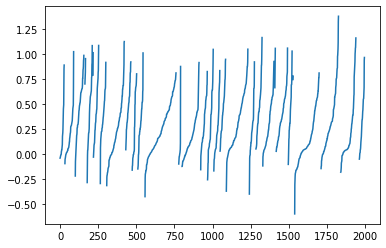

In [40]:
outputlist.sort()
plt.plot(outputlist[4000:6000])
plt.show()
#plt.plot(outputlist)
#plt.show()

In [21]:
okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[1506:1511].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[1511].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model1, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

IndexError: single positional indexer is out-of-bounds

In [4]:
def evaluate_episode(model, data, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [25]:
(278+13082)/(278+13082+2410+32)  #evaluation on 

0.8454625996709277

In [21]:
(278+13082+2410+32) 

15802

In [5]:

def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )

    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE       



In [10]:
def evaluatedataset(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),6):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+5]==0 or dataset[headers[h-1]].iloc[i+5]==1: #if label is 0 or 1  (ignores n/a values)

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                cutoff=0.5
                for k in range(len(cutofflist)):
                    if labelstest==1  and outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                    elif labelstest==1  and outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   
    GRUoutputlist.sort()
    plt.plot(GRUoutputlist)
    plt.show()
         

def evaluatedatasetlookahead(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),6):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+5]==0 or dataset[headers[h-1]].iloc[i+5]==1: #if label is 0 or 1  (ignores n/a values)

                classifytest=dataset[headers[h-10:h-1]].iloc[i:i+5].to_numpy()
                labelstest=dataset[headers[h-1]].iloc[i+5]
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

               
                for k in range(len(cutofflist)):
                    if labelstest==1  and outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                    elif labelstest==1  and outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   

    #GRUoutputlist.sort()
    #GRUoutputlist.sort()
    plt.plot(sorted(GRUoutputlist))
    plt.show()



In [15]:
gru_model1=torch.load('currentmodel_3datasets_1steplookhead_model1_10_24_2021.pt',map_location=torch.device('cpu'))
gru_model1.eval()
print("loaded")





loaded
loaded
loaded
loaded
loaded


In [18]:
row=897

headers=[]
for i in range(30):  
    label=str(i)
    headers.append("header"+label)

choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(10):  
    label=str(i)
    choppedheaders.append("header"+label)

okcounter=0
for i in range(20):
    classifytest=originaldata1[headers[i:10+i]].iloc[row*6:(row*6)+5].to_numpy()
    #print(classifytest)
    labelstest=originaldata1[headers[i:10+i]].iloc[(row*6)+5].to_numpy()
    print(labelstest)
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

IndexError: single positional indexer is out-of-bounds